In [361]:
from tqdm import tqdm
import sys
import datetime

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.rcParams["font.family"] = "Times New Roman"

In [362]:
data = pd.read_parquet("analysis_df_0416_1653.parquet")

In [364]:
table1 = (
    data[["mean_econ_price", "price_change", "prop_sales", "seats_sold"]]
    .describe(percentiles=[0.05, 0.5, 0.95])
    .assign(
        unique_fares=data.groupby(["train_id"])
        .agg(unique_fares=("mean_econ_price", "nunique"))
        .describe(percentiles=[0.05, 0.5, 0.95])
    )
    .round(2)
    .T.reset_index()
    .rename(columns={"50%": "median", "index": "Variable"})[
        ["Variable", "mean", "std", "median", "5%", "95%"]
    ]
    .to_latex()
)  # .to_excel("descriptive_raw.xlsx")

C:\Users\Velkey Artúr\AppData\Local\Temp\ipykernel_7356\347466124.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  ].to_latex()#.to_excel("descriptive_raw.xlsx")


In [365]:
with open("table1.txt", "w") as f:
    f.write(table1)

In [366]:
data["peak_hour"] = np.where(data["depart_hour"].isin([7, 8, 9]), 1, 0)

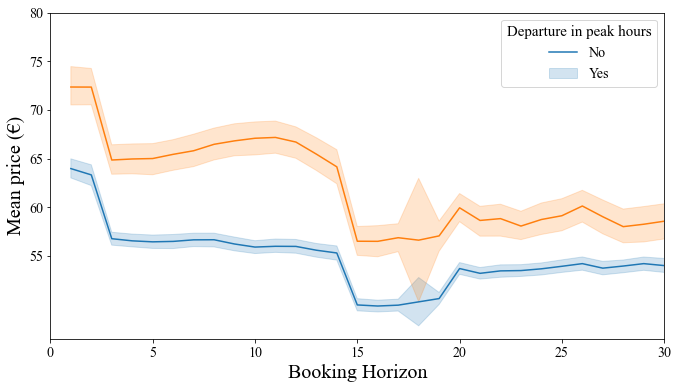

In [367]:
fig, ax = plt.subplots(figsize=(11, 6))

sns.lineplot(
    data=data,
    x="trend",
    y="mean_econ_price",
    estimator="mean",
    hue="peak_hour",
)  # .get_legend().remove()


plt.gca().invert_xaxis()

plt.xlabel("Booking Horizon", fontsize=20, fontweight=450)
plt.ylabel("Mean price (€)", fontsize=20, fontweight=450)

plt.xlim(0, 30)
# plt.ylim(75,90)
plt.legend(("No", "Yes"), loc="upper right", prop={"size": 14}).set_title(
    "Departure in peak hours", prop={"size": 15}
)

tick_max = 80
tick_interval = 5
ax.set_yticks(np.arange(55, tick_max + tick_interval, tick_interval))

# plt.title("Mean price evolution", fontsize=28, y=1.04)
plt.tick_params(axis="both", which="major", labelsize=14)

# plt.savefig("figures/fig4_peak_hour", dpi=300)
plt.show()

# peak hour difference in price

In [368]:
figdata = (
    pd.DataFrame(data.groupby("trend")["price_change_direction"].value_counts())
    .rename(columns={"price_change_direction": "sum"})
    .reset_index()
)

figdata = figdata.merge(
    figdata.groupby("trend")["sum"].sum().reset_index().rename(columns={"sum": "all"}),
    on="trend",
)

figdata["price_change_freq"] = figdata["sum"] / figdata["all"]

figdata = figdata.loc[figdata["price_change_direction"] != 0]

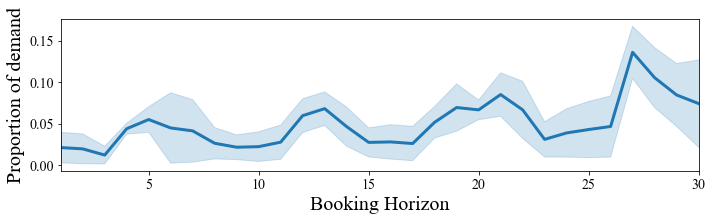

In [369]:
plt.figure(figsize=(10, 3))


figdata = (
    pd.DataFrame(data.groupby("trend")["price_change_direction"].value_counts())
    .rename(columns={"price_change_direction": "sum"})
    .reset_index()
)

figdata = figdata.merge(
    figdata.groupby("trend")["sum"].sum().reset_index().rename(columns={"sum": "all"}),
    on="trend",
)

figdata["price_change_freq"] = figdata["sum"] / figdata["all"]

figdata = figdata.loc[figdata["price_change_direction"] != 0]

# TOP FIG.
ax1 = plt.subplot(1, 1, 1)
sns.lineplot(
    data=figdata,
    x="trend",
    y="price_change_freq",
    palette="Set2",
    linewidth=3,
)

tick_max = 0.4
tick_min = 0
tick_interval = 0.1

# ax1.set_yticks(np.arange(tick_min, tick_max + tick_interval, tick_interval))
# plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


# ax1.legend(("Treated", "Untreated"), loc="upper left", prop={"size": 12}).set_title(
#    "Treatment", prop={"size": 12}
# )
ax1.set_xlim(1, 30)

ax.set_xlim(1, 30)
plt.xlabel("Booking Horizon", fontsize=20, fontweight=450)
plt.ylabel("Proportion of demand", fontsize=20, fontweight=450)


ax1.tick_params(axis="both", which="major", labelsize=14)


plt.tight_layout()
plt.savefig("Pincrease_freq.jpg", dpi=300)
# plt.title("Proportion of trains that's price increased", fontsize=28, y=1.04)

In [371]:
data["max_seat_capacity"] = 313
data["loading_factor"] = (
    (data["max_seat_capacity"] - data["mean_econ_seats"]) / data["max_seat_capacity"]
).round(2)

In [372]:
trains_to_keep = (
    pd.DataFrame(data.groupby("train_id")["trend"].first())
    .reset_index()
    .loc[lambda _df: _df["trend"] < 10, :]["train_id"]
    .to_list()
)

In [373]:
trains_to_keep2 = (
    pd.DataFrame(
        data.loc[lambda _df: _df["train_id"].isin(trains_to_keep), :]
        .groupby("train_id")["trend"]
        .last()
    )
    .reset_index()
    .loc[lambda _df: _df["trend"] > 25, :]["train_id"]
    .to_list()
)

In [384]:
figdata = data.loc[lambda _df: _df["train_id"].isin(trains_to_keep2), :].loc[
    lambda _df: _df["train_id"].isin(trains_to_keep), :
]

In [386]:
data.groupby("train_id")["treatment_somewhere"].mean().value_counts()

0.0    2811
1.0    2542
Name: treatment_somewhere, dtype: int64

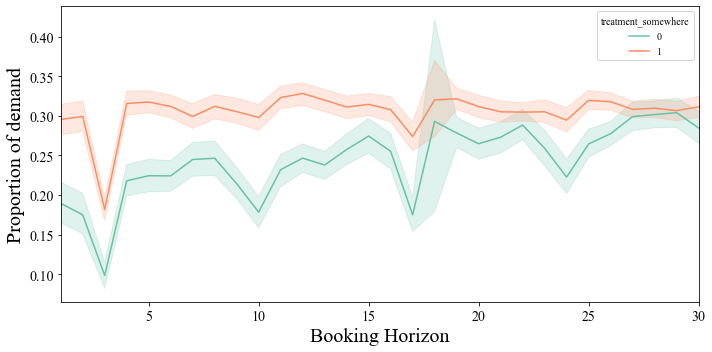

In [389]:
plt.figure(figsize=(10, 5))

# TOP FIG.
ax1 = plt.subplot(1, 1, 1)

sns.lineplot(
    data=figdata,
    x="trend",
    y="prop_sales",
    estimator="mean",
    hue="treatment_somewhere",
    palette="Set2",
)
plt.gca().invert_xaxis()

tick_max = 0.4
tick_min = 0
tick_interval = 0.1

# ax1.set_yticks(np.arange(tick_min, tick_max + tick_interval, tick_interval))
# plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


# ax1.legend(("Treated", "Untreated"), loc="upper left", prop={"size": 12}).set_title(
#    "Treatment", prop={"size": 12}
# )
ax1.set_xlim(1, 30)

ax.set_xlim(1, 30)
plt.xlabel("Booking Horizon", fontsize=20, fontweight=450)
plt.ylabel("Proportion of demand", fontsize=20, fontweight=450)


ax1.tick_params(axis="both", which="major", labelsize=14)

plt.tight_layout()
plt.savefig("demand_on_horizon.jpg", dpi=300)
# plt.title("Proportion of trains that's price increased", fontsize=28, y=1.04)

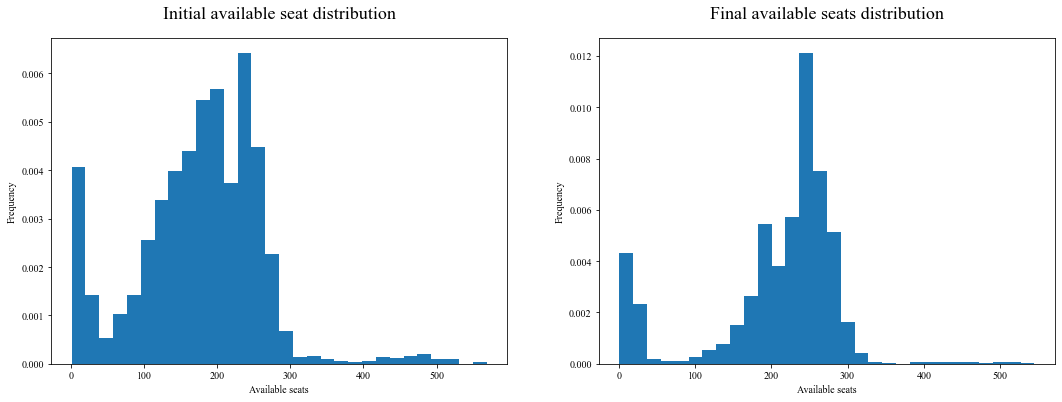

In [379]:
figdata = data.sort_values(by=["train_id", "trend"]).groupby("train_id")[
    "mean_econ_seats"
]

plt.figure(figsize=(18, 6))

ax1 = plt.subplot(1, 2, 1)
# ax1.set_xlim(35, 110)
# ax1.set_ylim(0, 0.14)
ax1.hist(figdata.last(), bins=30, density=True)
plt.xlabel("Available seats", fontsize=10, fontweight=450)
plt.ylabel("Frequency", fontsize=10, fontweight=450)

plt.title("Initial available seat distribution", fontsize=18, y=1.04)


ax2 = plt.subplot(1, 2, 2)
# ax3.set_xlim(35, 110)
# ax3.set_ylim(0, 0.14)
ax2.hist(figdata.first(), bins=30, density=True)
plt.xlabel("Available seats", fontsize=10, fontweight=450)
plt.ylabel("Frequency", fontsize=10, fontweight=450)

plt.title("Final available seats distribution", fontsize=18, y=1.04)
plt.savefig("distributions.jpg", dpi=300)


plt.show()

In [380]:
data2 = pd.read_parquet("analysis_df.parquet")

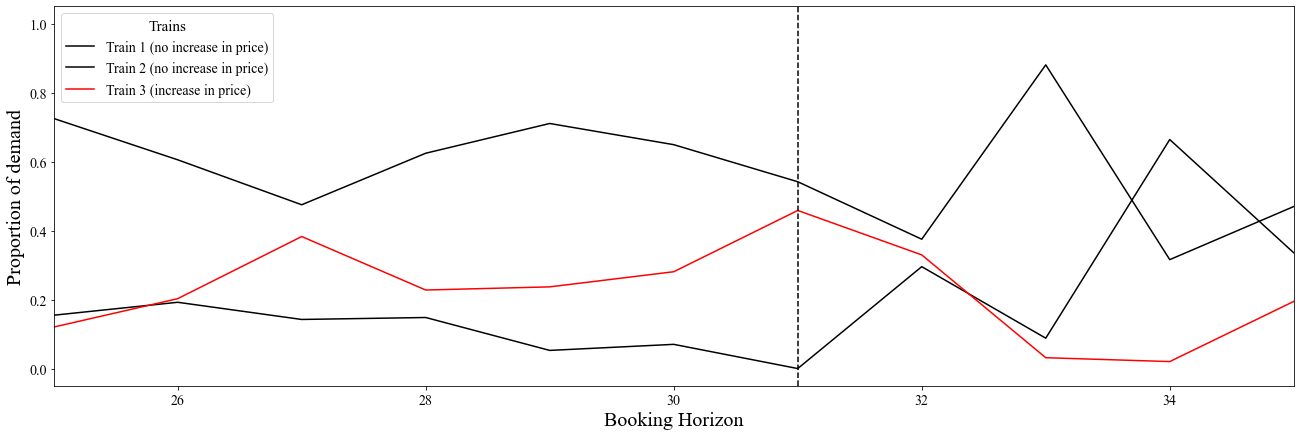

In [390]:
plt.figure(figsize=(18, 6))

ax1 = plt.subplot(1, 1, 1)

np.where(data["depart_hour"].isin([7, 8, 9]), 1, 0)
sns.lineplot(
    data=data2.loc[lambda _df: _df["group_id"] == 207, :].assign(
        increased_train=lambda x: np.where(
            x["train_id"] == "ALICANTEMADRID2020-03-18 08:34:002020-03-18 11:10:00",
            1,
            0,
        )
    ),
    x="trend",
    y="prop_sales",
    estimator="mean",
    hue="train_id",
    palette=["black", "black", "red"],
)

plt.legend(
    (
        "Train 1 (no increase in price)",
        "Train 2 (no increase in price)",
        "Train 3 (increase in price)",
    ),
    loc="upper left",
    prop={"size": 14},
).set_title("Trains", prop={"size": 15})

plt.axvline(31, 0, 1, color="black", linestyle="--", linewidth=1.5)
ax1.set_xlim(25, 35)

plt.tight_layout()
plt.xlabel("Booking Horizon", fontsize=20, fontweight=450)
plt.ylabel("Proportion of demand", fontsize=20, fontweight=450)
plt.tick_params(axis="both", which="major", labelsize=14)

plt.savefig("example.jpg", dpi=300)